<a href="https://colab.research.google.com/github/AgnelFernando/BCI_UR3/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy scipy pandas scikit-learn

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Data Preparation

In [4]:
left_channels = pd.read_csv("/content/drive/MyDrive/OpenBCI/left/left_2025-07-15_13:55:21.csv")

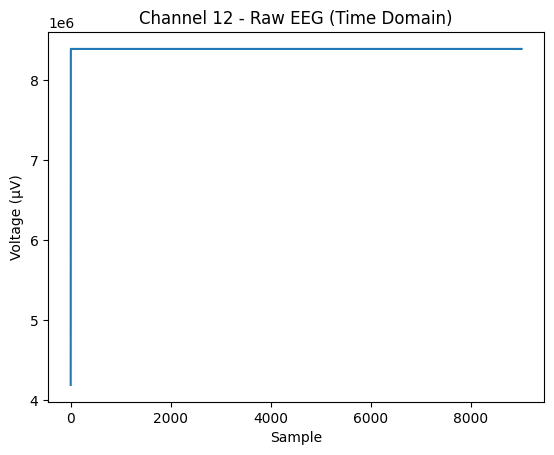

In [5]:
import matplotlib.pyplot as plt

# Plot 5 seconds from channel 0
channel = 12
start, end = 0, 50 * 250  # 5 sec at 250Hz
plt.plot(left_channels.iloc[start:end, channel])
plt.title(f"Channel {channel} - Raw EEG (Time Domain)")
plt.xlabel("Sample")
plt.ylabel("Voltage (µV)")
plt.show()

In [17]:
print(left_channels.describe())

                Ch1           Ch2           Ch3           Ch4            Ch5  \
count  8.772000e+03  8.772000e+03  8.772000e+03  8.772000e+03    8772.000000   
mean   1.562138e+06  1.674150e+06 -3.115515e+06 -2.605351e+06 -679734.602371   
std    1.176162e+05  1.340184e+05  1.450689e+05  1.363386e+05  139818.683414   
min    6.821510e+05  6.906980e+05 -3.357939e+06 -2.836053e+06 -904863.000000   
25%    1.434759e+06  1.581650e+06 -3.278668e+06 -2.759904e+06 -839687.750000   
50%    1.576258e+06  1.687330e+06 -3.096152e+06 -2.586717e+06 -663463.500000   
75%    1.677874e+06  1.800837e+06 -2.988300e+06 -2.486549e+06 -557333.750000   
max    1.735609e+06  1.841170e+06 -1.677870e+06 -1.417388e+06 -448183.000000   

                Ch6           Ch7           Ch8            Ch9          Ch10  \
count  8.772000e+03  8.772000e+03  8.772000e+03    8772.000000  8.772000e+03   
mean  -1.167615e+06  8.388129e+06 -1.504089e+06 -643033.442202 -8.388130e+06   
std    1.273600e+05  4.478273e+04  1.33

### Power Spectral Density (PSD) Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_psd(df):
  fs = 250
  eeg_data = df.iloc[:, :16]

  plt.figure(figsize=(10, 6))
  for ch in range(eeg_data.shape[1]):
      f, Pxx = welch(eeg_data.iloc[:, ch], fs=fs, nperseg=512)
      plt.semilogy(f, Pxx, label=f"Ch {ch}")

  plt.title("Power Spectral Density (All 16 Channels)")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Power Spectral Density")
  plt.xlim(0, 50)  # EEG relevant range
  plt.grid(True)
  plt.legend(ncol=4, fontsize=8)
  plt.tight_layout()
  plt.show()


In [ ]:
# Left channels

left_channels = pd.read_csv("/content/drive/MyDrive/OpenBCI/left/left_2025-07-15_13:20:42.csv")
plot_psd(left_channels)

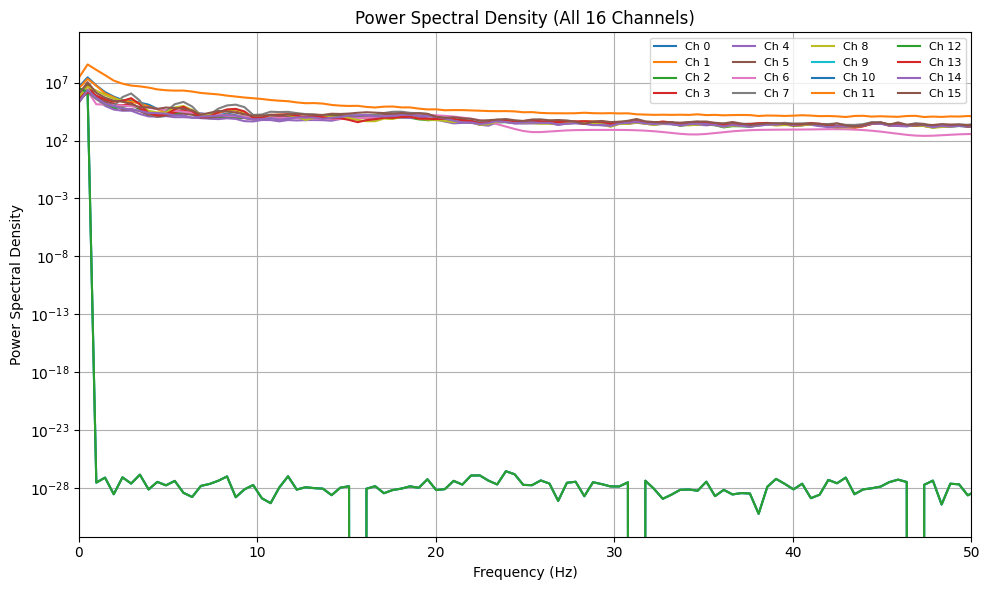

In [29]:
# Right channels

right_channels = pd.read_csv("/content/drive/MyDrive/OpenBCI/right/right_2025-07-15_13:52:29.csv")
plot_psd(right_channels)

In [8]:
SAMPLING_RATE = 250
WINDOW_SIZE = SAMPLING_RATE * 1
STRIDE = SAMPLING_RATE // 2
BANDPASS_LOW = 1
BANDPASS_HIGH = 40

In [9]:
def bandpass_filter(data, low, high, fs):
    b, a = butter(N=4, Wn=[low / (fs/2), high / (fs/2)], btype='band')
    return filtfilt(b, a, data, axis=0)

def segment_windows(data, window_size, stride):
    windows = []
    for start in range(0, data.shape[0] - window_size + 1, stride):
        end = start + window_size
        windows.append(data[start:end])
    return np.stack(windows)

def preprocess_file(file_path, label):
    df = pd.read_csv(file_path)
    eeg_data = df.iloc[:, :16].drop(df.columns[11], axis=1).values

    filtered = bandpass_filter(eeg_data, BANDPASS_LOW, BANDPASS_HIGH, SAMPLING_RATE)

    scaler = StandardScaler()
    normalized = scaler.fit_transform(filtered)

    windows = segment_windows(normalized, WINDOW_SIZE, STRIDE)
    labels = np.full((len(windows),), label)

    return windows, labels

task_to_label = {'left': 0, 'right': 1, 'up': 2, 'down': 3}

def process_dataset(data_dir):
    all_X, all_y = [], []
    for task in os.listdir(data_dir):
      for file in os.listdir(data_dir + "/" + task):
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, task, file)
            label = task_to_label[task]
            X, y = preprocess_file(file_path, label)
            all_X.append(X)
            all_y.append(y)

    X = np.concatenate(all_X, axis=0)
    y = np.concatenate(all_y, axis=0)
    return X, y

In [10]:
data_dir = '/content/drive/MyDrive/OpenBCI'
X, y = process_dataset(data_dir)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (518, 250, 15)
Shape of y: (518,)


In [11]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].T, self.y[idx]

In [16]:
class SimpleEEGNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleEEGNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(15, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(64 * 62, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
model = SimpleEEGNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

Epoch 1 - Loss: 17.4647
Epoch 2 - Loss: 14.6134
Epoch 3 - Loss: 12.3322
Epoch 4 - Loss: 9.9450
Epoch 5 - Loss: 8.0813
Epoch 6 - Loss: 6.2479
Epoch 7 - Loss: 5.2058
Epoch 8 - Loss: 4.4547
Epoch 9 - Loss: 3.1634
Epoch 10 - Loss: 3.2506


In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 76.92%


# LSTM

In [21]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size=16, hidden_size=64, num_layers=2, num_classes=4):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [22]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
model = EEG_LSTM(input_size=15, hidden_size=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [25]:
train_losses = []

for epoch in range(200):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss)
    if epoch % 5 == 0:
      print(f"Epoch {epoch+1:02d} | Train Loss: {running_train_loss:.4f}")

Epoch 01 | Train Loss: 18.0310
Epoch 06 | Train Loss: 15.5909
Epoch 11 | Train Loss: 13.7279
Epoch 16 | Train Loss: 12.9392
Epoch 21 | Train Loss: 11.5032
Epoch 26 | Train Loss: 15.3045
Epoch 31 | Train Loss: 14.0253
Epoch 36 | Train Loss: 13.9609
Epoch 41 | Train Loss: 14.2192
Epoch 46 | Train Loss: 13.8446
Epoch 51 | Train Loss: 13.6042
Epoch 56 | Train Loss: 13.7562
Epoch 61 | Train Loss: 14.2625
Epoch 66 | Train Loss: 12.8363
Epoch 71 | Train Loss: 12.9042
Epoch 76 | Train Loss: 16.3008
Epoch 81 | Train Loss: 15.0159
Epoch 86 | Train Loss: 15.3805
Epoch 91 | Train Loss: 15.0551
Epoch 96 | Train Loss: 14.8093
Epoch 101 | Train Loss: 14.6177
Epoch 106 | Train Loss: 15.3064
Epoch 111 | Train Loss: 13.4232
Epoch 116 | Train Loss: 14.5207
Epoch 121 | Train Loss: 12.7520
Epoch 126 | Train Loss: 12.1950
Epoch 131 | Train Loss: 14.4877
Epoch 136 | Train Loss: 13.6603
Epoch 141 | Train Loss: 13.6852
Epoch 146 | Train Loss: 17.0291
Epoch 151 | Train Loss: 17.1908
Epoch 156 | Train Loss: 17.1

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 60.77%


# GRU

In [27]:
class EEG_GRU(nn.Module):
    def __init__(self, input_size=16, hidden_size=64, num_layers=2, num_classes=4, dropout=0.3):
        super(EEG_GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)


In [28]:
model = EEG_GRU(input_size=15, hidden_size=64, num_layers=2, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
train_losses = []

for epoch in range(100):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss)
    if epoch % 5 == 0:
      print(f"Epoch {epoch+1:02d} | Train Loss: {running_train_loss:.4f}")

Epoch 01 | Train Loss: 18.0679
Epoch 06 | Train Loss: 14.6074
Epoch 11 | Train Loss: 12.7020
Epoch 16 | Train Loss: 11.7048
Epoch 21 | Train Loss: 9.9510
Epoch 26 | Train Loss: 8.2890
Epoch 31 | Train Loss: 13.5795
Epoch 36 | Train Loss: 8.0382
Epoch 41 | Train Loss: 7.4975
Epoch 46 | Train Loss: 6.2318
Epoch 51 | Train Loss: 3.8974
Epoch 56 | Train Loss: 3.0130
Epoch 61 | Train Loss: 2.8400
Epoch 66 | Train Loss: 2.3224
Epoch 71 | Train Loss: 3.0085
Epoch 76 | Train Loss: 1.7138
Epoch 81 | Train Loss: 1.8657
Epoch 86 | Train Loss: 2.8199
Epoch 91 | Train Loss: 1.8674
Epoch 96 | Train Loss: 1.5930


In [30]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 80.77%


In [32]:
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': 15,
    'hidden_size': 64,
    'num_layers': 2,
    'num_classes': 4
}, "eeg_gru_checkpoint.pth")

## Inference

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

SAMPLING_RATE = 250
BANDPASS_LOW = 1
BANDPASS_HIGH = 40

def bandpass_filter(data, low, high, fs):
    b, a = butter(N=4, Wn=[low / (fs / 2), high / (fs / 2)], btype='band')
    return filtfilt(b, a, data, axis=0)

def preprocess_live_eeg(raw_window):
    """
    raw_window: np.array of shape (250, 16)
    returns: processed_window of shape (250, 15)
    """
    assert raw_window.shape == (250, 16), "Expected raw EEG shape (250, 16)"

    raw_window = np.delete(raw_window, 11, axis=1)  # → (250, 15)

    filtered = bandpass_filter(raw_window, BANDPASS_LOW, BANDPASS_HIGH, SAMPLING_RATE)

    scaler = StandardScaler()
    normalized = scaler.fit_transform(filtered)

    return normalized


In [ ]:
class EEG_GRU(nn.Module):
    def __init__(self, input_size=15, hidden_size=64, num_layers=2, num_classes=4, dropout=0.3):
        super(EEG_GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

In [ ]:
def inference(raw_eeg_window: np.ndarray, model_path="eeg_gru_model.pth"):
    processed = preprocess_live_eeg(raw_eeg_window)  # (250, 15)

    model = EEG_GRU()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()

    with torch.no_grad():
        x = torch.tensor(processed, dtype=torch.float32).unsqueeze(0)  # (1, 250, 15)
        output = model(x)
        pred = torch.argmax(output, dim=1).item()

    return pred
